In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.layers import Input , Conv2D , BatchNormalization , MaxPooling2D , Dropout , Flatten , Dense , GlobalAveragePooling2D
from keras.models import Sequential
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import ResNet50
import tensorflow as tf

In [ ]:
!cp -r "/content/drive/MyDrive/data" /content

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     zoom_range=0.05,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     brightness_range = [0.5, 1.4],
                                     validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory="data",
                                                    batch_size=10,
                                                    target_size=(224, 224),
                                                    shuffle = True,
                                                    subset = "training")

validation_generator = train_datagen.flow_from_directory(directory="data",
                                                            batch_size=10,
                                                            target_size=(224, 224),
                                                            shuffle = False,
                                                            subset = "validation")

Found 133 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


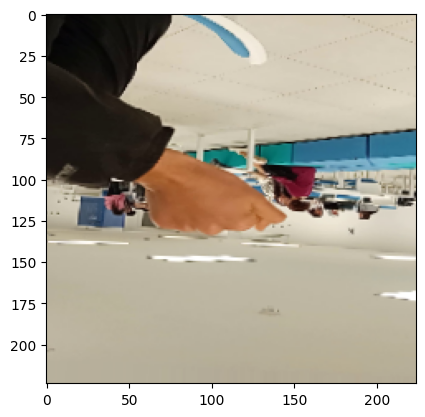

[0. 1.]


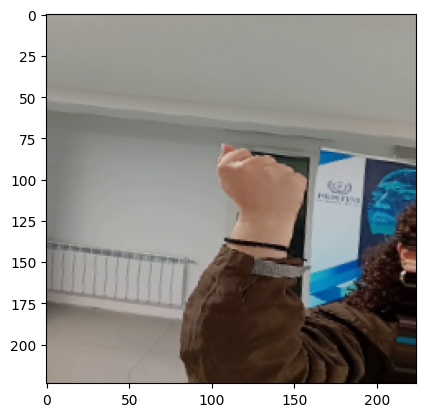

[0. 1.]


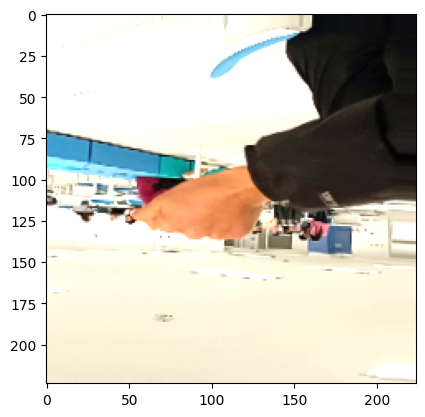

[0. 1.]


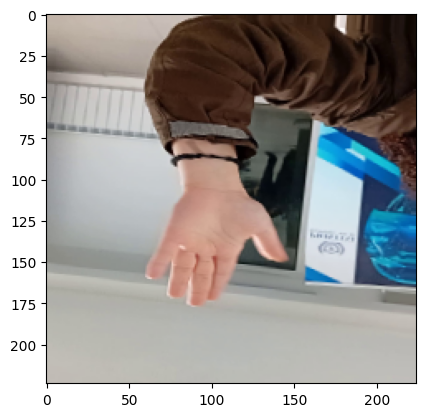

[1. 0.]


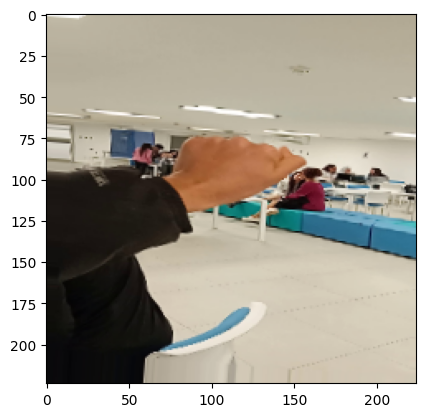

[0. 1.]


In [ ]:
for my_batch in train_generator :
  images = my_batch[0]
  labels = my_batch[1]
  for i in range(5):
    plt.imshow(images[i])
    plt.show()
    print(labels[i])
  break

In [ ]:
base_model = MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

model = tf.keras.Sequential([
                              base_model,
                              GlobalAveragePooling2D(),
                              Dense(512, activation = 'relu'),
                              Dropout(rate = 0.2),
                              Dense(2, activation='softmax')
                            ])

model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.00008),
                loss = "categorical_crossentropy",
                metrics=["accuracy"])

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf

class AccuracyStop(tf.keras.callbacks.Callback):
    def __init__(self, threshold=0.99):
        super(AccuracyStop, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        if accuracy >= self.threshold:
            print(f"\nReached accuracy of {self.threshold}. Stopping training.")
            self.model.stop_training = True
accuracy_stop = AccuracyStop(threshold=0.99)

In [ ]:
history = model.fit(train_generator,epochs = 20, validation_data = validation_generator)

Epoch 1/20
14/14 [==============================] - 9s 650ms/step - loss: 0.0362 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9688
Epoch 2/20
14/14 [==============================] - 12s 900ms/step - loss: 0.0464 - accuracy: 0.9925 - val_loss: 0.1063 - val_accuracy: 0.9375
Epoch 3/20
14/14 [==============================] - 11s 759ms/step - loss: 0.0263 - accuracy: 1.0000 - val_loss: 0.0495 - val_accuracy: 1.0000
Epoch 4/20
14/14 [==============================] - 10s 694ms/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.0614 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 10s 679ms/step - loss: 0.0196 - accuracy: 0.9925 - val_loss: 0.0497 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 11s 751ms/step - loss: 0.0208 - accuracy: 1.0000 - val_loss: 0.0536 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 10s 737ms/step - loss: 0.0177 - accuracy: 1.0000 - val_loss: 0.0412 - val_accuracy: 1.0000


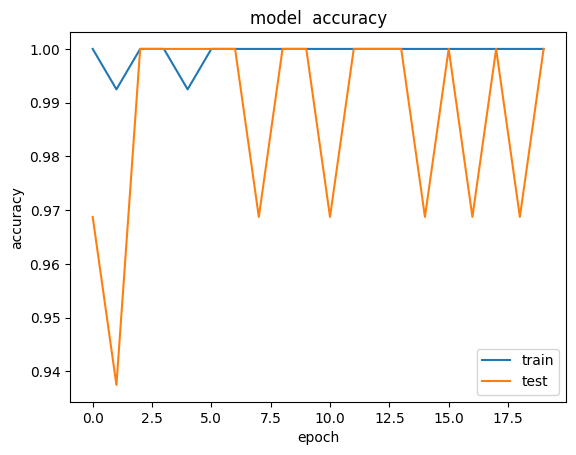

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model  accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

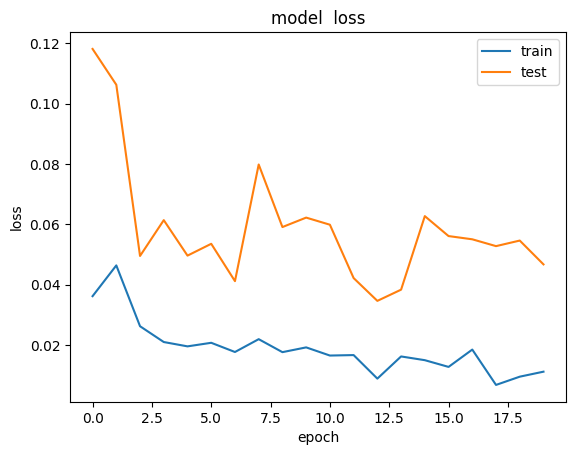

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model  loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
model.save('need_help.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

<IPython.core.display.Javascript object>

(480, 640)
Saved to test.jpg


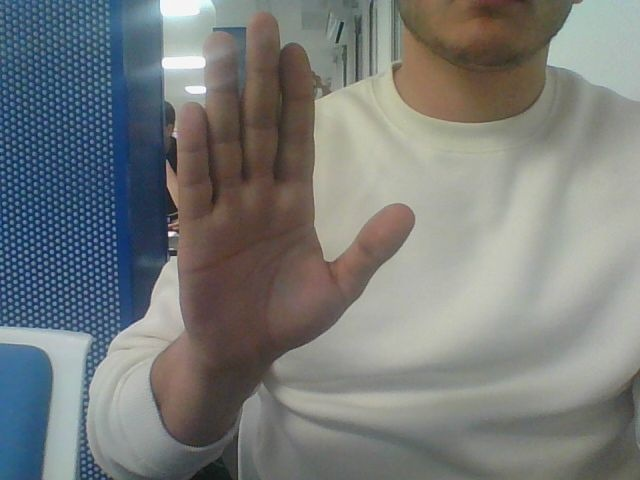

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import numpy as np
import cv2

try:
  filename = take_photo('test.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
from skimage import io
from PIL import Image as image
test=[]
im = io.imread("/content/test.jpg")
im = image.fromarray(im ,'RGB')
im = im.resize((224,224))
im = np.array(im) /255.0
test.append(np.array(im))

In [ ]:
test = tf.reshape(test, (-1, 224, 224, 3))
pred = model.predict(test)

1/1 [==============================] - 0s 56ms/step


In [ ]:
pred

array([[0.16937712, 0.83062285]], dtype=float32)